### Машинное Обучения

## Домашнее задание №2 - Дерево решений

**Общая информация**

**Срок сдачи:** 23 апреля 2024, 23:59   
**Штраф за опоздание:** -2 балла за каждые 2 дня опоздания

Решений залить в свой github репозиторий.

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс MyDecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict . (Но название класса не менять)

In [320]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

In [390]:
import numpy as np
from collections import Counter

def gini_impurity(x):
    value_counts = dict(Counter(x))
    n = len(x)
    p_sum = 0
    for key in value_counts.keys():
        p_sum += (value_counts[key] / n) ** 2
    gini = 1 - p_sum
    return gini

def entropy_impurity(x):
    value_counts = dict(Counter(x))
    n = len(x)
    enthopy = 0
    for key in value_counts.keys():
        enthopy -= (value_counts[key] / n) * np.log(value_counts[key] / n) 
    return enthopy
    
def loss_impurity(x):
    value_counts = dict(Counter(x))
    n = len(x)
    
    return 1 - max(value_counts.values()) / n

In [395]:
n0 = 3
n1 = 8
n = n0 + n1
x = [0] * n0 + [1] * n1
entropy_impurity(x)

0.5859526183035508

In [404]:
- n0 / n * np.log(n0 / n1) - np.log(n1) + np.log(n)

0.585952618303551

In [400]:
- (n0 / n) * np.log(n0 / n) - (n1 / n) * np.log(n1 / n)

0.5859526183035508

In [3]:
impurity_dict = {'gini': gini_impurity,
                 'entropy': entropy_impurity,
                 'loss': loss_impurity}

In [448]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = []
        self.criterion = criterion
        self.impurity = impurity_dict[criterion]
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """

        max_score = -float('inf')
        best_feature = None
        best_threshold = None

        heterogeneity_all = self.impurity(y)
        n = x.shape[0]

        for feature in range(x.shape[1]):
            values = sorted(list(set(x[:, feature])))
            for thres in values[:-1]:
                x_left, x_right, y_left, y_right = self.__div_samples(x, y, feature, thres)

                heterogeneity_left = x_left.shape[0] / n * self.impurity(y_left)
                heterogeneity_right = x_right.shape[0] / n * self.impurity(y_right)
                score = heterogeneity_all - heterogeneity_left - heterogeneity_right
                if score > max_score:
                    max_score = score
                    best_feature = feature
                    best_threshold = thres 

        return best_feature, best_threshold

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        if depth == self.max_depth or x.shape[0] < self.min_samples_split:

            prediction = max(y, key=lambda x: list(y).count(x))
            probability = list(y).count(prediction) / len(y)
            self.tree[node_id] = (self.__class__.LEAF_TYPE, prediction, probability)

        else:
            best_feature, best_threshold = self.__find_threshold(x, y)
            self.feature_importances_.append(best_feature)
            x_left, x_right, y_left, y_right = self.__div_samples(x, y, best_feature, best_threshold)
            self.tree[node_id] = (self.__class__.NON_LEAF_TYPE, best_feature, best_threshold)
            self.__fit_node(x_left, y_left, 2 * node_id + 1, depth + 1)
            self.__fit_node(x_right, y_right, 2 * node_id + 2, depth + 1)

    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        dic = dict(Counter(self.feature_importances_))
        dic = dict(sorted(dic.items(), key=lambda x:x[1], reverse=True))

        return dic

In [498]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [499]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [500]:
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [501]:
print(f"sklearn model acc: {accuracy_score(y_pred=clf.predict(X_test), y_true=y_test):.3f}")
print(f"my model acc: {accuracy_score(y_pred=my_clf.fit_predict(X_train, y_train, X_test), y_true=y_test):.3f}")

sklearn model acc: 0.833
my model acc: 0.944


Совет: Проверьте, что ваша реализация корректно работает с признаками в которых встречаются повторы. 
И подумайте, какие еще граничные случаи могут быть.
Например, проверьте, что на таком примере ваша модель корректно работает:

In [502]:
X = np.array([[1] * 10, [0, 1, 2, 5, 6, 3, 4, 7, 8, 9]]).T
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
for depth in range(1, 5):
    my_clf = MyDecisionTreeClassifier(max_depth=depth)
    my_clf.fit(X, y)
    print("DEPTH:", depth, "\n\t\tTree:", my_clf.tree, my_clf.predict(X))

DEPTH: 1 
		Tree: {0: (0, 1, 2), 1: (1, 1, 0.7142857142857143), 2: (1, 0, 1.0)} [0 0 0 1 1 1 1 1 1 1]
DEPTH: 2 
		Tree: {0: (0, 1, 2), 1: (0, 1, 6), 3: (1, 1, 1.0), 4: (1, 0, 0.5), 2: (0, 1, 0), 5: (1, 0, 1.0), 6: (1, 0, 1.0)} [0 0 0 0 0 0 0 1 1 1]
DEPTH: 3 
		Tree: {0: (0, 1, 2), 1: (0, 1, 6), 3: (0, 1, 7), 7: (1, 1, 1.0), 8: (1, 1, 1.0), 4: (0, 1, 4), 9: (1, 0, 1.0), 10: (1, 1, 1.0), 2: (0, 1, 0), 5: (0, 1, 1), 11: (1, 0, 1.0), 12: (1, 0, 1.0), 6: (1, 0, 1.0)} [0 0 0 0 0 1 1 1 1 1]
DEPTH: 4 
		Tree: {0: (0, 1, 2), 1: (0, 1, 6), 3: (0, 1, 7), 7: (0, 1, 8), 15: (1, 1, 1.0), 16: (1, 1, 1.0), 8: (1, 1, 1.0), 4: (0, 1, 4), 9: (0, 1, 5), 19: (1, 0, 1.0), 20: (1, 0, 1.0), 10: (0, 1, 3), 21: (1, 1, 1.0), 22: (1, 1, 1.0), 2: (0, 1, 0), 5: (0, 1, 1), 11: (1, 0, 1.0), 12: (1, 0, 1.0), 6: (1, 0, 1.0)} [0 0 0 0 0 1 1 1 1 1]


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [515]:
%time clf.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 1 ms


DecisionTreeClassifier()

In [516]:
%time my_clf.fit(X_train, y_train)

CPU times: total: 46.9 ms
Wall time: 98.5 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Данные и описания колонок во вложениях.

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Либо воспользоваться функцией:

In [53]:
def fil_categorical_feature(df, col):
    df[col] = df[col].fillna('dummy')
    values = df[col].unique()
    map_dict = {value: df[df[col] == value]['match'].mean() for value in values}
    return df[col].apply(lambda x: map_dict[x])

In [167]:
def fil_hobby_features(df, col):
    df[f"{col}_match"] = np.zeros(df.shape[0])
    df[col] = df[col].fillna(df[col].median())
    col_list = list(df.columns)
    col_index = col_list.index(col)
    pid_index = col_list.index('pid')
    new_index = col_list.index(f"{col}_match")
    
    for p in range(df.shape[0]):
        p_rate = df.iloc[p, col_index]
        pid = df.iloc[p, pid_index]
        try:
            partner_rate = df[df['iid'] == pid].iloc[0, col_index]
        except IndexError:
            print(p, pid)
        df.iloc[p, new_index] = np.abs(partner_rate - p_rate)
    return df[f"{col}_match"]
        

In [265]:
def add_expectations_reality(df):
    expectations = ['pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha']
    reality = ['attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o']
    df['real_sum'] = df[reality].sum(axis=1)
    for expect, feature in zip(expectations, reality):
        new_feature_name = f"{feature[:-2]}_fail"
        df[new_feature_name] = df[feature] / df['real_sum'] * 100 - df[expect]
        
        if not "total_fail" in df.columns:
            df["total_fail"] = df[new_feature_name]
        else:
            df["total_fail"] += df[new_feature_name]
            
    return df
    

In [518]:
def preprocess_spd_data(df):
    df = df.iloc[:, :97]
    df = add_expectations_reality(df)
    # df['person_sum'] = df[['pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha']].sum(axis=1)
    # df['partner_sum'] = df[['attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o']].sum(axis=1)
    # df['diff_sum'] = np.abs(10 * df['partner_sum'] -  df['person_sum'])
    df['race_feature'] = df['samerace'] *  df['imprace']
    df['age_diff'] = np.abs(df['age_o'] - df['age'])
    
    df = df.dropna(subset=['pid'], axis=0)
    
    to_drop = [
        'id', 'idg', 'wave', 'position', 'positin1', 'order', 'partner', 
        # 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
        # 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o','met_o',
        'field',  'zipcode', 'income', 'tuition', 'mn_sat', 'undergra', 'career', 
         'expnum',
    ]
    
    hobbies = ['sports', 'tvsports', 'exercise', 
            'dining', 'museums', 'art', 'hiking', 'gaming', 
            'clubbing', 'reading', 'tv', 'theater', 'movies', 
            'concerts', 'music', 'shopping', 'yoga',
        ]
    
    pbar = tqdm(hobbies)
    
    for hobby in pbar:
        pbar.set_description(f'Matching hobby {hobby}')
        df[hobby] = df[hobby].fillna(df[hobby].median())
        df[f"{hobby}_match"] = fil_hobby_features(df, hobby)
        
        if not "total_match" in df.columns:
            df["total_match"] = df[f"{hobby}_match"]
        else:
            df["total_match"] += df[f"{hobby}_match"]
        
    df = df.drop(hobbies, axis=1)
    
    categorical = ['condtn', 'round', 'field_cd', 'samerace', 'race_o',
                    'career_c', 'goal', 'date', 'from',
                    'go_out',
    ]
    
    df = df.drop(to_drop, axis=1)
    df = df.dropna(subset=['age', 'imprelig', 'imprace', 'date'])
    
    for col in categorical:
        df[col] = fil_categorical_feature(df, col)
    
    # attr1 processing
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 
                                            'amb1_1', 'shar1_1']].sum(axis=1)
    df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] =\
    (df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T / 
     df.loc[:, 'temp_totalsum'].T).T * 100
    
    # attr2 processing
    df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 
                                            'amb2_1', 'shar2_1']].sum(axis=1)
    df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] =\
    (df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T / 
     df.loc[:, 'temp_totalsum'].T).T * 100
    df = df.drop(['temp_totalsum'], axis=1)
    
    for i in [4, 5]:
        feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
                'intel{}_1'.format(i), 'fun{}_1'.format(i), 
                'amb{}_1'.format(i), 'shar{}_1'.format(i)]

        if i != 4:
            feat.remove('shar{}_1'.format(i))
    
        df = df.drop(feat, axis=1)
    
    df = df.dropna()
    return df

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. В качестве метрики можно взять roc-auc. 


In [519]:
df = pd.read_csv("Speed_Dating_Data.csv", encoding='latin1')

In [520]:
df = preprocess_spd_data(df)

Matching hobby sports:   0%|          | 0/17 [00:00<?, ?it/s]

Matching hobby yoga: 100%|██████████| 17/17 [01:06<00:00,  3.92s/it]    


In [521]:
y = df['match']
X = df.drop(['match', 'iid', 'pid'], axis=1)

In [522]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.10, random_state=42, stratify=y)

In [361]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=12, criterion='entropy')

In [362]:
print(f"my clf roc auc: {roc_auc_score(y_score=my_clf.fit_predict(X_train, y_train, X_test), y_true=y_test):.3f}")

my clf roc auc: 0.734


In [363]:
print(f"my clf precision: {precision_score(y_pred=my_clf.predict(X_test), y_true=y_test):.3f}")

my clf precision: 0.562


In [364]:
print(f"my clf recall: {recall_score(y_pred=my_clf.predict(X_test), y_true=y_test):.3f}")

my clf recall: 0.558


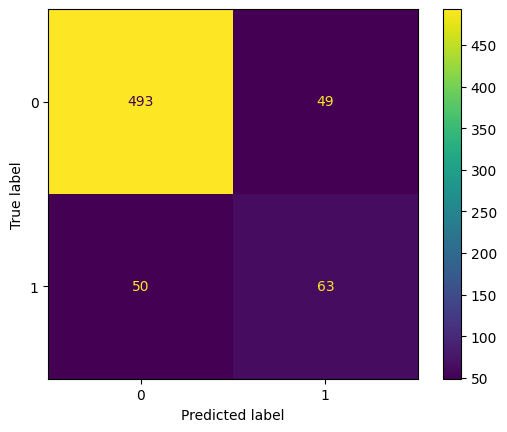

In [365]:
cm = confusion_matrix(y_pred=my_clf.predict(X_test), y_true=y_test)
ConfusionMatrixDisplay(cm).plot()

Потестим, как справится рандомный предиктор

In [377]:
random_pred = np.random.choice(y_train, y_test.shape[0], replace=True)

In [378]:
print(f"rand clf roc auc: {roc_auc_score(y_score=random_pred, y_true=y_test):.3f}")

rand clf roc auc: 0.488


In [379]:
print(f"rand clf precision: {precision_score(y_pred=random_pred, y_true=y_test):.3f}")

rand clf precision: 0.151


In [380]:
print(f"rand clf recall: {recall_score(y_pred=random_pred, y_true=y_test):.3f}")

rand clf recall: 0.142


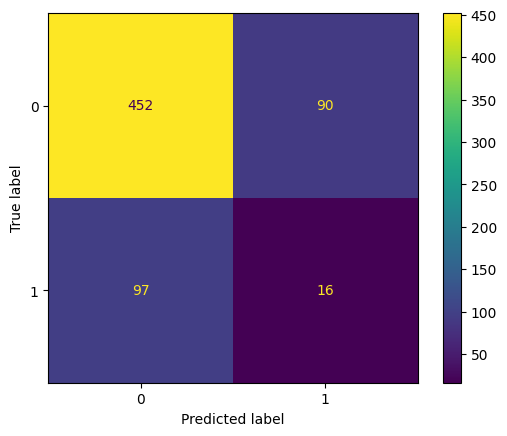

In [381]:
cm = confusion_matrix(y_pred=random_pred, y_true=y_test)
ConfusionMatrixDisplay(cm).plot()

Наш сильно лучше

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации и трейне от глубины дерева, от минимального числа объектов для сплита. (Т.е должно быть 2 графика, на каждой должны быть 2 кривые - для трейна и валидации)
Какой максимальной точности удалось достигнуть?

In [382]:
for criterion in ['entropy', 'gini', 'loss']:
    my_clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=12, criterion=criterion)
    print(f"criterion: {criterion}, my model roc auc: {roc_auc_score(y_score=my_clf.fit_predict(X_train, y_train, X_test), y_true=y_test):.3f}")

criterion: entropy, my model roc auc: 0.734
criterion: gini, my model roc auc: 0.729
criterion: loss, my model roc auc: 0.543


Выберем энтропию

In [385]:
train_roc_auc_depths = []
test_roc_auc_depths = []
train_acc_depths = []
test_acc_depths = []

all_depths = list(range(2, 15)) + list(range(20, 55, 5)) + list(range(60, 125, 20))
pbar = tqdm(all_depths)

for depth in pbar:
    pbar.set_description(f"fitting depth {depth}")
    
    my_clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=depth, criterion='entropy')
    my_clf.fit(X_train, y_train)
    
    pred_test = my_clf.predict(X_test)
    pred_train = my_clf.predict(X_train)
    
    train_roc_auc = roc_auc_score(y_score=pred_train, y_true=y_train)
    test_roc_auc = roc_auc_score(y_score=pred_test, y_true=y_test)
    train_acc = accuracy_score(y_pred=pred_train, y_true=y_train)
    test_acc = accuracy_score(y_pred=pred_test, y_true=y_test)
    
    train_roc_auc_depths.append(train_roc_auc)
    test_roc_auc_depths.append(test_roc_auc)
    train_acc_depths.append(train_acc)
    test_acc_depths.append(test_acc)

fitting depth 120: 100%|██████████| 24/24 [26:47<00:00, 67.00s/it] 


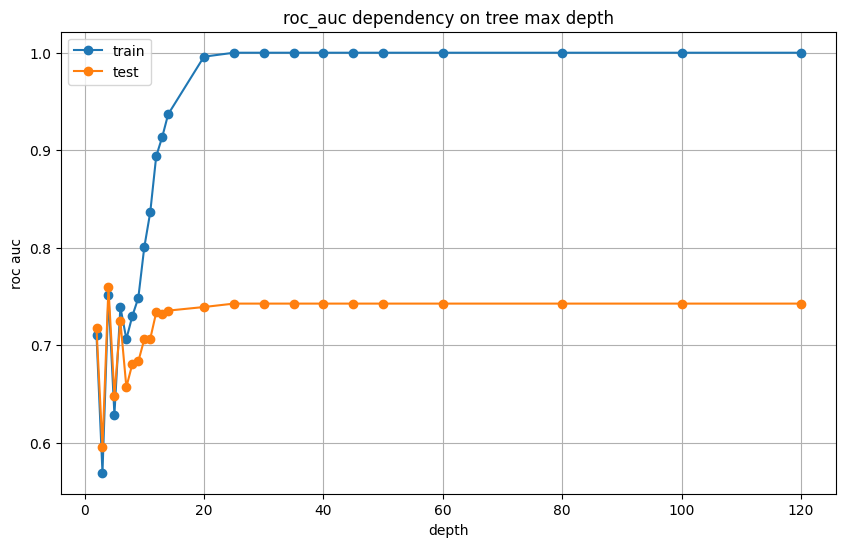

In [387]:
plt.figure(figsize=(10, 6))
plt.title("roc_auc dependency on tree max depth")
plt.grid(True)
plt.plot(all_depths, train_roc_auc_depths, 'o-', label='train')
plt.plot(all_depths, test_roc_auc_depths, 'o-', label='test')
plt.ylabel("roc auc")
plt.xlabel("depth")
plt.legend()
plt.show()

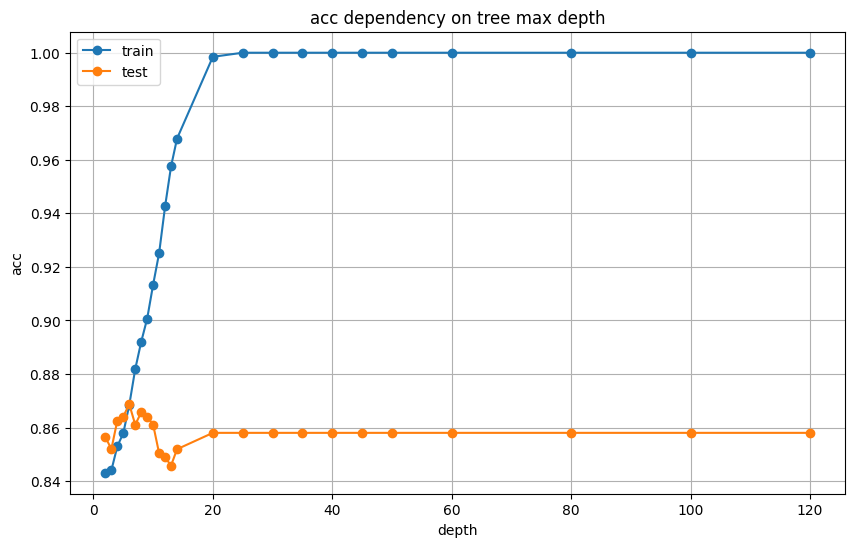

In [388]:
plt.figure(figsize=(10, 6))
plt.title("acc dependency on tree max depth")
plt.grid(True)
plt.plot(all_depths, train_acc_depths, 'o-', label='train')
plt.plot(all_depths, test_acc_depths, 'o-', label='test')
plt.ylabel("acc")
plt.xlabel("depth")
plt.legend()
plt.show()

In [525]:
train_roc_auc_minsplits = []
test_roc_auc_minsplits = []
train_acc_minsplits = []
test_acc_minsplits = []

all_minsplits = list(range(2, 15)) + list(range(20, 55, 5)) + list(range(60, 125, 20))
pbar = tqdm(all_minsplits)

for minsplit in pbar:
    pbar.set_description(f"fitting minsplit {minsplit}")
    
    my_clf = MyDecisionTreeClassifier(min_samples_split=minsplit, max_depth=12, criterion='entropy')
    my_clf.fit(X_train, y_train)
    
    pred_test = my_clf.predict(X_test)
    pred_train = my_clf.predict(X_train)
    
    train_roc_auc = roc_auc_score(y_score=pred_train, y_true=y_train)
    test_roc_auc = roc_auc_score(y_score=pred_test, y_true=y_test)
    train_acc = accuracy_score(y_pred=pred_train, y_true=y_train)
    test_acc = accuracy_score(y_pred=pred_test, y_true=y_test)
    
    train_roc_auc_minsplits.append(train_roc_auc)
    test_roc_auc_minsplits.append(test_roc_auc)
    train_acc_minsplits.append(train_acc)
    test_acc_minsplits.append(test_acc)

fitting minsplit 120: 100%|██████████| 24/24 [21:34<00:00, 53.95s/it]


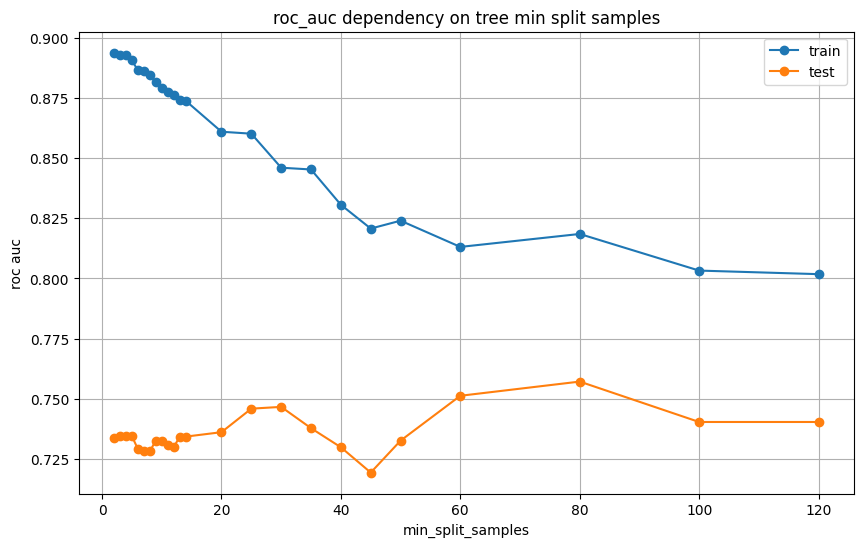

In [526]:
plt.figure(figsize=(10, 6))
plt.title("roc_auc dependency on tree min split samples")
plt.grid(True)
plt.plot(all_minsplits, train_roc_auc_minsplits, 'o-', label='train')
plt.plot(all_minsplits, test_roc_auc_minsplits, 'o-', label='test')
plt.ylabel("roc auc")
plt.xlabel("min_split_samples")
plt.legend()
plt.show()

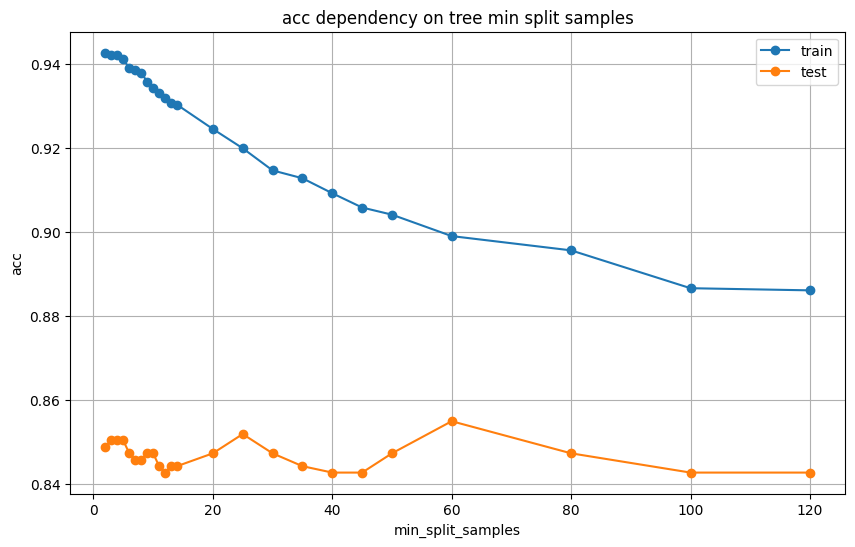

In [527]:
plt.figure(figsize=(10, 6))
plt.title("acc dependency on tree min split samples")
plt.grid(True)
plt.plot(all_minsplits, train_acc_minsplits, 'o-', label='train')
plt.plot(all_minsplits, test_acc_minsplits, 'o-', label='test')
plt.ylabel("acc")
plt.xlabel("min_split_samples")
plt.legend()
plt.show()

Известным фактом является то, что деревья решений сильно переобучаются при увеличении глубины и просто запоминают трейн. 
Замечаете ли вы такой эффект судя по графикам? Что при этом происходит с качеством на валидации? 

Для max_depth: Начиная с какого-то момента, метрики на вале не растут, а метрики на трэйне близится к 1, кристаллическое переобучение

Для min_samples_split: Зафиксировав оптимальный параметр max_depth, наблюдаем, как повышение min_samples_split ведёт к росту метрик на валидации с параллельным падением метрик на трэйне, что говорит о регуляризации, сокращении переобучения. Это продолжается вплоть до некого оптимального значения, после чего обе метрики падают ввиду недообучения.  

Прикольно, что если не убирать iid и pid из фичей, они становятся одними из "важнейших" признаков 

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

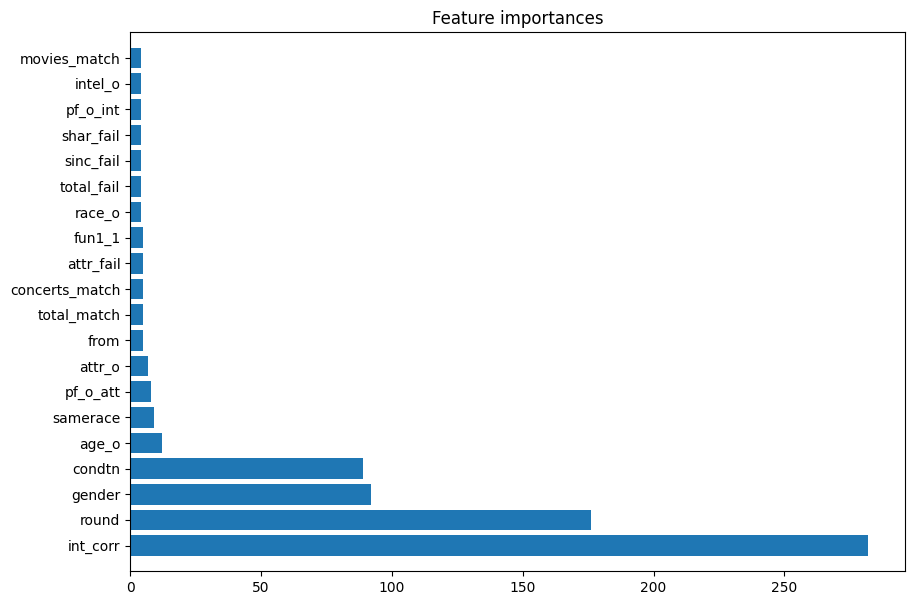

In [355]:
importance = my_clf.get_feature_importance()

plt.figure(figsize=(10,7))
plt.title(f"Feature importances")
plt.barh(range(20), np.array(list(importance.values()))[:20], align="center")
plt.yticks(range(20), X.columns[np.array(list(importance.keys()))[:20]])
plt.ylim([-1, 20])
plt.show()

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

